# Task 1 Data Visualisation:  
(45 Minutes Max)

Consider the best way to visualise this data. 

1) Create some key components that may be used within a data visualisation dashboard to present your analysis to other data scientists and/or a wider audience.  
2) As you explore the data, please note down any questions or concerns that come to mind, along with any insights and conclusions that you are able to draw using the visualisation components that you have built.


## Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar as cal
from datetime import datetime

In [3]:
pd.options.display.float_format = '{:.4f}'.format

## Get Data

In [4]:
data_path = "../data/raw/Horses.csv"
df = pd.read_csv(data_path)

### First Look

In [6]:
pd.set_option('display.max_columns', df.shape[1])

In [7]:
df.shape

(36819, 46)

In [8]:
df.head()

,RaceID,HorseID,Cloth,Stall,WeightValue,JockeyID,AllowanceValue,OverweightValue,TrainerID,OwnerID,LastRunDaysFlat,Age,Blinkers,Hood,Visor,EyeShield,Eyecover,TongueStrap,CheekPieces,ForecastPrice,StatCourse,StatDistance,StatCourseDistance,StartingPrice,Bred,DamID,SireID,DamSireID,Sex,Colour,YearBorn,MeetingID,RaceNumber,ScheduledTime,HorseCount,Runners,Going,Weather,Course_Distance,RaceType,TrackType,Handicap,eligibility,CourseID,MeetingDate,Won
0,989418,2963489,7,5.0000,132,1398052.0000,nan,nan,1198534,1289143.0000,26.0000,3.0000,nan,nan,nan,nan,nan,nan,nan,16-Jan,nan,nan,nan,12-Jan,SAF,2803520.0000,2004880.0000,2179351.0000,f,b,nan,87048,1,##########,13,11.0000,Good,Cloudy,1312,Flat,Turf,nan,2YO only,380,02/05/2017,0
1,989418,2972665,13,6.0000,132,1165412.0000,nan,nan,1188128,1140080.0000,nan,3.0000,nan,nan,nan,nan,nan,nan,nan,20-Jan,nan,nan,nan,40/1,SAF,2749301.0000,2960049.0000,2001540.0000,f,b,nan,87048,1,##########,13,11.0000,Good,Cloudy,1312,Flat,Turf,nan,2YO only,380,02/05/2017,0
2,989418,2972662,9,7.0000,132,1239852.0000,nan,nan,1199122,1448576.0000,nan,3.0000,nan,nan,nan,nan,nan,nan,nan,10-Jan,nan,nan,nan,NaN,SAF,2761722.0000,2441786.0000,2123459.0000,f,b,nan,87048,1,##########,13,11.0000,Good,Cloudy,1312,Flat,Turf,nan,2YO only,380,02/05/2017,0
3,989418,2960365,1,12.0000,132,1417524.0000,nan,nan,1049637,1487690.0000,33.0000,3.0000,nan,nan,nan,nan,nan,nan,nan,07-Apr,nan,nan,nan,11-Oct,SAF,2347111.0000,2170013.0000,2071137.0000,f,b,nan,87048,1,##########,13,11.0000,Good,Cloudy,1312,Flat,Turf,nan,2YO only,380,02/05/2017,1
4,989418,2968596,11,8.0000,132,1354773.0000,nan,nan,1140041,1403676.0000,24.0000,3.0000,nan,nan,nan,nan,nan,nan,nan,08-Jan,nan,nan,nan,NaN,SAF,2618721.0000,2410998.0000,2170115.0000,f,b,nan,87048,1,##########,13,11.0000,Good,Cloudy,1312,Flat,Turf,nan,2YO only,380,02/05/2017,0


* Lots of nulls, particularly variables describing tack  
* **ForecastPrice** & **StartingPrice** look like they should be odds, but have been corrupted to a date string.  
* No Data Dictionary for this dataset! Unsure what an AllowanceValue is etc.


### How many races has each horse won?  
Getting a sense of the class imbalance in a binary problem; win/ didn't win.

In [9]:
races_per_horse = df['HorseID'].value_counts()
winners = df.groupby('HorseID').agg({'Won': 'sum'})
winners.columns = ['won']
winners.reset_index()

winners = winners.merge(races_per_horse, left_index=True, right_index=True)
winners = winners.rename(columns=({'HorseID': 'total_races'}))
winners['win_pct'] = winners.won / winners.total_races

In [10]:
winners['win_pct'].describe()

count   6064.0000
mean       0.0753
std        0.1407
min        0.0000
25%        0.0000
50%        0.0000
75%        0.1250
max        1.0000
Name: win_pct, dtype: float64

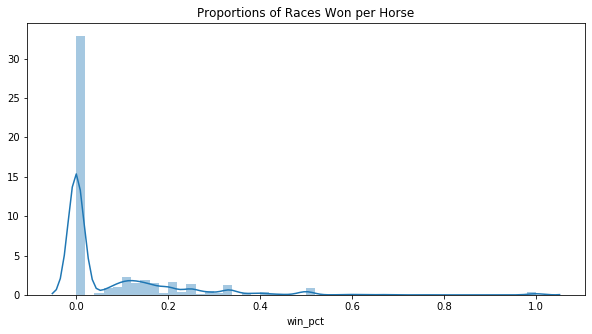

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Proportions of Races Won per Horse')
sns.distplot(winners.win_pct)
plt.show()

In [12]:
f"{int(len(winners[winners.won == 0]) / len(winners) * 100)}% haven't won"

"65% haven't won"

There are 6,064 horses in the dataset and 3,986 haven't won - so actually this dataset isn't an imbalanced as I might have thought and I probably don't need to consider over sampling the minority class.

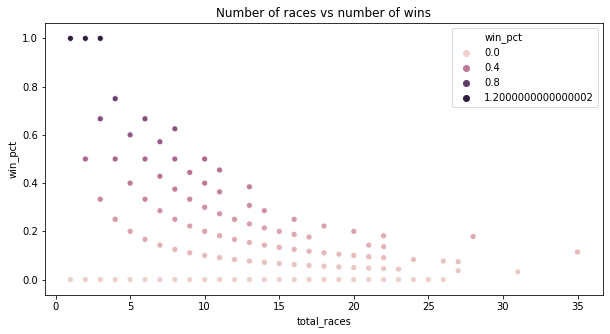

In [13]:
plt.figure(figsize=(10, 5))
plt.title('Number of races vs number of wins')
sns.scatterplot(x='total_races', y='win_pct', data=winners, hue='win_pct')
plt.show()

Horses with a 100% track record have raced very few times.

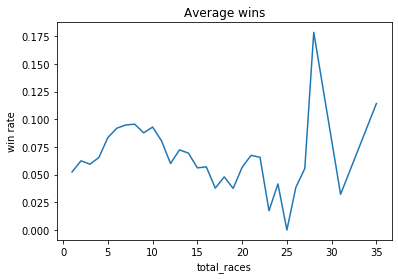

In [14]:
plt.title('Average wins')
plt.plot(winners.groupby('total_races').mean()['win_pct'])
plt.xlabel('total_races')
plt.ylabel('win rate')
plt.show()

There's a trade-off between experience and maturity;  It looks like horses running between 5 and 10 races have proportionately more wins.  

Capturing the horse's prior form will be advantageous to modelling.

### How large is the field in each race?  
In order to predict the winner of the race, it would be helpful to consider the competition.

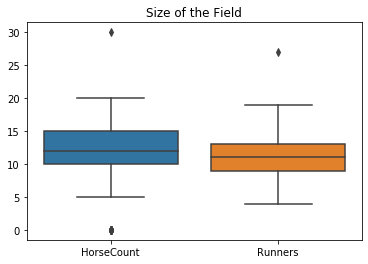

In [15]:
entrants = df.groupby('RaceID').agg({'HorseCount': 'mean',
                                    'Runners': 'mean'})

sns.boxplot(data=entrants)
plt.title('Size of the Field')
plt.show()

On average there are around 12 entrants per race with 1 non-starter. The IQR is ~5 to 20, but there are some exceptions with more than 25 horses racing. 

### Taking a look at the ID variables, are these discrete values useful?

In [16]:
# grabbing discrete ID vars
id_cols = [col for col in df.columns if 'id' in col.lower()]
id_cols

['RaceID',
 'HorseID',
 'JockeyID',
 'TrainerID',
 'OwnerID',
 'DamID',
 'SireID',
 'DamSireID',
 'MeetingID',
 'CourseID']

In [17]:
# cardinality
for col in id_cols:
    print(f"""{col}: {len(df[col].unique())}""")

RaceID: 3000
HorseID: 6064
JockeyID: 249
TrainerID: 160
OwnerID: 3078
DamID: 4182
SireID: 297
DamSireID: 734
MeetingID: 344
CourseID: 8


The ID variables have quite high cardinality but seem to contain some useful information about breeding, trainers etc.  A neural net embedding might be a useful approach to learn numerical representations of this data.

In [18]:
# are there as many winners as there are races?
df.Won.sum()

2907

There isn't a winner for each race! Given the time I won't investigate this further, but I would figure out what these rows of data are, possibly duplicates or redundant?

## Data Prep   
From here I am processing the data for modelling and continue to explore distributions etc...

### Nulls

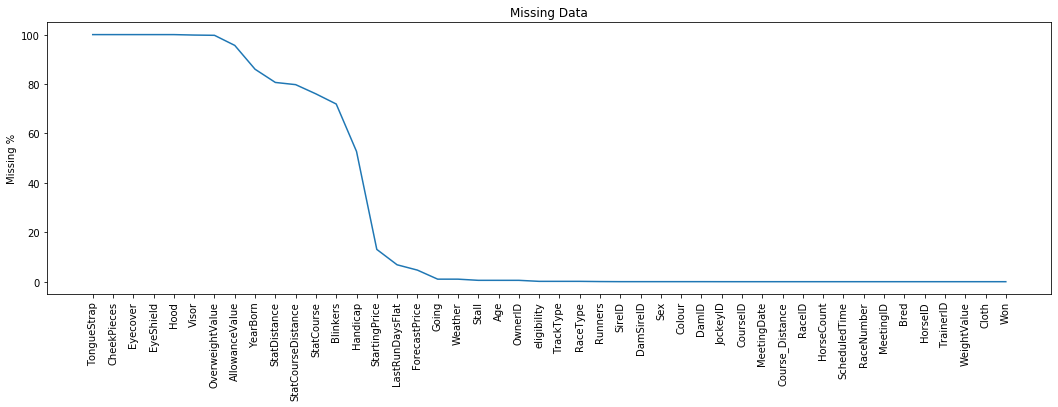

In [19]:
missings = (pd.DataFrame(index=df.isnull().sum().index,
                         data=df.isnull().sum().values / len(df) * 100,
                         columns=['missing_pct'])
            .sort_values(by='missing_pct', ascending=False))

plt.figure(figsize=(18, 5))
plt.plot(missings)
plt.title('Missing Data')
plt.ylabel('Missing %')
plt.xticks(rotation=90)
plt.show()

In [20]:
lots_missing = missings[missings.missing_pct > 60]
lots_missing

,missing_pct
TongueStrap,100.0000
CheekPieces,100.0000
Eyecover,100.0000
EyeShield,100.0000
Hood,100.0000
Visor,99.8153
OverweightValue,99.7121
AllowanceValue,95.6300
YearBorn,85.9855
StatDistance,80.6404


Some variables either don't contain any information or have too much missing data to infer a meaningful value.  I will record these and remove from model training. 

In [21]:
# record these cols to remove from a modelling dset.
cols_to_remove = list(lots_missing.index.values)

In [22]:
# handicap has a lot of nulls, so taking a look to see how to deal with nulls
print(df.Handicap.value_counts(dropna=False))

# will replaces nulls with zero...
df['Handicap'] = df['Handicap'].fillna(0)

nan       19413
1.0000    17347
0.0000       59
Name: Handicap, dtype: int64


## Correct prices  
The prices look like odds and will be super useful for modelling!  They have been corrupted and some values are stored as date strings.

In [23]:
prices = [col for col in df.columns if 'price' in col.lower()]
df[prices].head()

,ForecastPrice,StartingPrice
0,16-Jan,12-Jan
1,20-Jan,40/1
2,10-Jan,NaN
3,07-Apr,11-Oct
4,08-Jan,NaN


In [24]:
# create a dictionary to convert month strings to number...
cal_dict = dict(enumerate(cal.month_abbr))

# flip dictionary keys and values round the right way for mapping.
cal_dict = {v: k for (k, v) in cal_dict.items()}


def correct_odds(col: str, split_char: str) -> pd.Series:
    """Convert price column from corrupted fractional odds to a decimal.
    Parameters
    ----------
    col: str
        name of column containing prices to correct
    split_char: str
        the character used to split the column
    Returns
    -------
    A pandas series containing the decimal odds.
    """
    has_char = df[col].str.contains(split_char)

    split_vals = (df[col]
                  [has_char.fillna(False)]
                  .str.split(split_char))

    numer, denom = split_vals.str[0], split_vals.str[1]

    try:
        numer, denom = numer.astype(int), denom.astype(int)
    except ValueError:
        numer = (numer
                 .replace('Aug', '8')
                 .replace('', 1)
                 .astype(int))

        denom = pd.Series([int(x)
                           if x.isnumeric()
                           else cal_dict[x]
                           for x in denom])
        denom.index = numer.index

    return numer / denom


# apply the function above to the two price columns and fix both "-" and "/"
corrected = {}
for col, char in [(col, char) for col in prices for char in ['-', '/']]:
    print(col, char)
    corrected[f'{col}{char}'] = correct_odds(col, char)

ForecastPrice -
ForecastPrice /
StartingPrice -
StartingPrice /


### Fill ForecastPrice

In [25]:
# update dataframe
df['forecast_price_cleaned'] = pd.concat([corrected['ForecastPrice-'],
                                          corrected['ForecastPrice/']])
df['forecast_price_cleaned'] = (df['forecast_price_cleaned']
                                .fillna(df['ForecastPrice']))

In [26]:
df['forecast_price_cleaned'].describe()

count   35092.0000
mean       14.7389
std        13.4107
min         0.2000
25%         6.0000
50%        10.0000
75%        20.0000
max       100.0000
Name: forecast_price_cleaned, dtype: float64

In [27]:
mean_price = df['forecast_price_cleaned'].mean()
df['forecast_price_cleaned'] = df['forecast_price_cleaned'].fillna(mean_price)

In [28]:
df[['ForecastPrice', 'forecast_price_cleaned']].head()

,ForecastPrice,forecast_price_cleaned
0,16-Jan,16.0000
1,20-Jan,20.0000
2,10-Jan,10.0000
3,07-Apr,1.7500
4,08-Jan,8.0000


### Fill StartingPrice

In [29]:
# update dataframe
df['starting_price_cleaned'] = pd.concat([corrected['StartingPrice-'],
                                          corrected['StartingPrice/']])
df['starting_price_cleaned'] = (df['starting_price_cleaned']
                                .fillna(df['StartingPrice']))

In [30]:
df['starting_price_cleaned'].describe()

count   32009.0000
mean       20.6992
std        22.7877
min         0.1111
25%         5.5000
50%        12.0000
75%        28.0000
max       150.0000
Name: starting_price_cleaned, dtype: float64

In [31]:
mean_price = df['starting_price_cleaned'].mean()
df['starting_price_cleaned'] = df['starting_price_cleaned'].fillna(mean_price)

In [32]:
df[['StartingPrice', 'starting_price_cleaned']].head()

,StartingPrice,starting_price_cleaned
0,12-Jan,12.0000
1,40/1,40.0000
2,NaN,20.6992
3,11-Oct,1.1000
4,NaN,20.6992


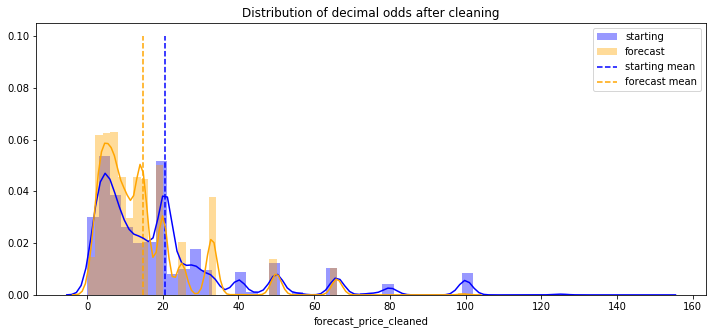

In [33]:
plt.figure(figsize=(12, 5))
plt.title('Distribution of decimal odds after cleaning')
sns.distplot(df['starting_price_cleaned'], label='starting', color='b')
plt.vlines(df['starting_price_cleaned'].mean(),
           ymin=0, ymax=0.1, colors='b',
           linestyles='--', label='starting mean')

sns.distplot(df['forecast_price_cleaned'], label='forecast', color='orange')
plt.vlines(df['forecast_price_cleaned'].mean(),
           ymin=0, ymax=0.1, colors='orange',
           linestyles='--', label='forecast mean')
plt.legend()
plt.show()

On average the return increases closer to the race.

In [34]:
cols_to_remove.extend(prices)

Below I have created a variable that tracks the change in price.  I've assumed that `forecast` is a pre-race value, whilst `starting price` is an updated value at the point of the race starting.

In [35]:
df['price_chg'] = df['starting_price_cleaned'] / df['forecast_price_cleaned']

In [36]:
df[['forecast_price_cleaned', 'starting_price_cleaned', 'price_chg']].head()

,forecast_price_cleaned,starting_price_cleaned,price_chg
0,16.0000,12.0000,0.7500
1,20.0000,40.0000,2.0000
2,10.0000,20.6992,2.0699
3,1.7500,1.1000,0.6286
4,8.0000,20.6992,2.5874


If the price change is less than 1, the return has reduced, which means that the odds of winning have increased.

# <font color= orange> 45 mins got me to here! </font>  

But I spent a bit more time visualising the data.

## Categorical variables...  
Are they all IDs? Should I one-hot encode?

In [37]:
cats = df.select_dtypes('object').columns

# ignore the columns I'll be removing
cats = list(set(cats).difference(cols_to_remove))

In [38]:
df[cats].head()

,eligibility,RaceType,Going,Weather,Bred,ScheduledTime,TrackType,Colour,MeetingDate,Sex
0,2YO only,Flat,Good,Cloudy,SAF,##########,Turf,b,02/05/2017,f
1,2YO only,Flat,Good,Cloudy,SAF,##########,Turf,b,02/05/2017,f
2,2YO only,Flat,Good,Cloudy,SAF,##########,Turf,b,02/05/2017,f
3,2YO only,Flat,Good,Cloudy,SAF,##########,Turf,b,02/05/2017,f
4,2YO only,Flat,Good,Cloudy,SAF,##########,Turf,b,02/05/2017,f


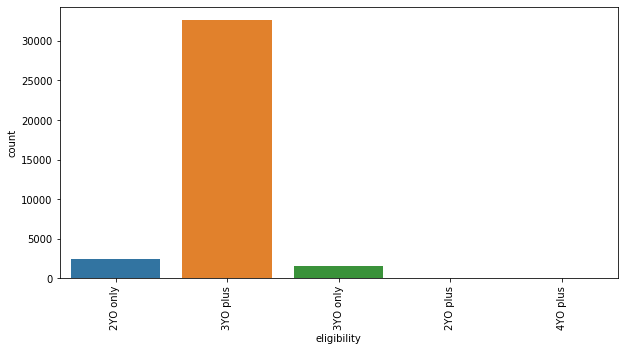

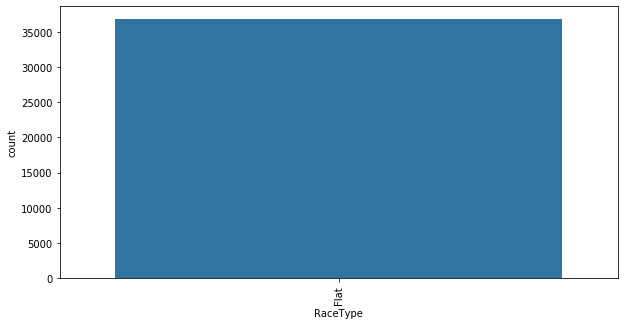

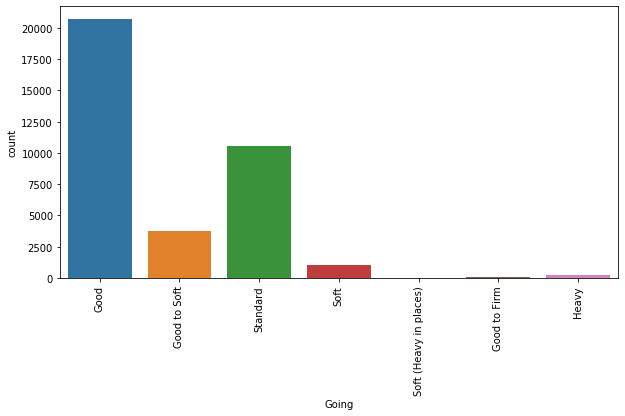

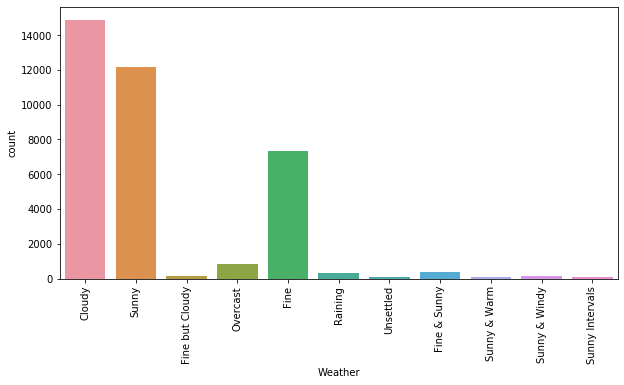

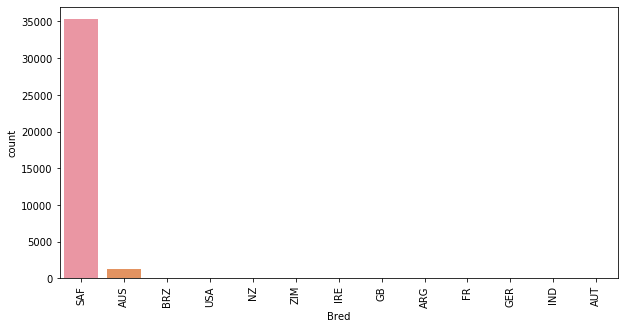

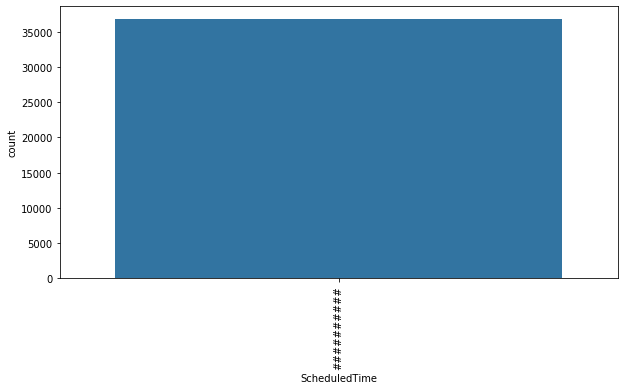

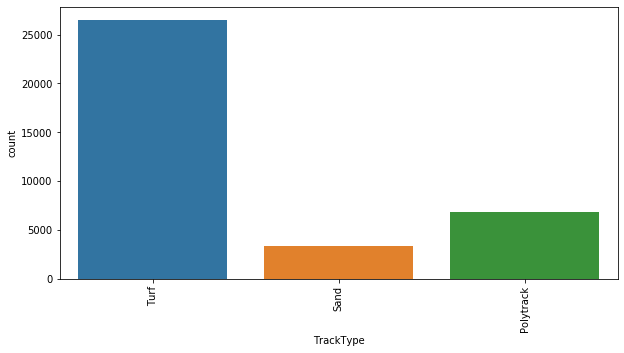

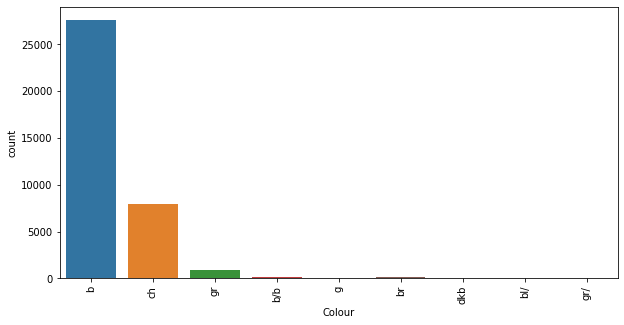

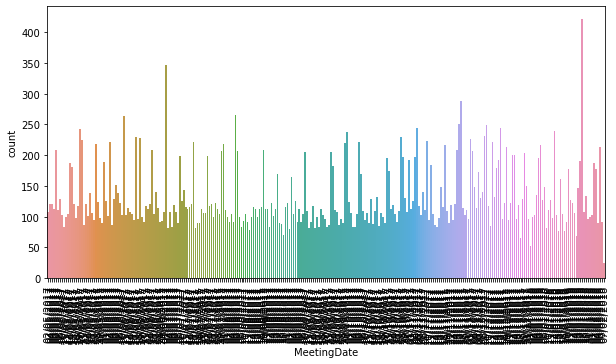

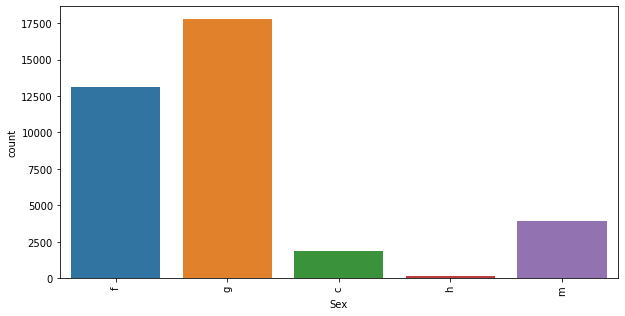

In [39]:
for c in cats:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=c, data=df)
    plt.xticks(rotation=90)
    plt.show()

In [40]:
cols_to_remove.extend(['RaceType',  # all flat races
                       'ScheduledTime',  # corrupted date
                      ])

### Create dummy variables  

Creating dummy variables in prep for random forest modelling - however, these categorical variables don't look very predictive in isolation but given more time I would build some lag features, eg/ the horses previous performance in different weather conditions or track surfaces etc.

In [41]:
for c in ['RaceType', 'MeetingDate', 'ScheduledTime']:
    cats.remove(c)

In [42]:
cats

['eligibility', 'Going', 'Weather', 'Bred', 'TrackType', 'Colour', 'Sex']

In [43]:
for c in cats:
    df = df.merge(pd.get_dummies(df[c], prefix=c), left_index=True, right_index=True)

In [44]:
cols_to_remove.extend(cats)

### Convert MeetingDate to a date format
This will enable the lag features I mention above and allow me to cut the train, val and test sets by time - as we probably want to predict the likelihood of winning a future race, and not just any race!

In [45]:
print(df.MeetingDate.dtype)  

df['MeetingDate'] = df['MeetingDate'].apply(datetime.strptime, args=(['%d/%m/%Y']))

object


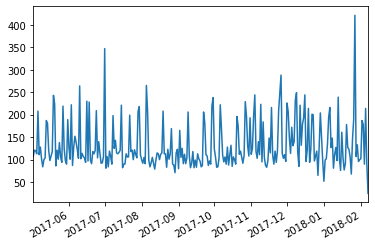

In [46]:
df['MeetingDate'].value_counts().plot()

## Continous Variables

In [47]:
df_cont = df.drop(columns=cols_to_remove + id_cols).select_dtypes('number')

In [48]:
keep = list(df_cont.iloc[:, :14].columns.values)
keep.remove('Won')
len(keep)

13

In [54]:
# quickly fixing nulls so that the plots below work
df_cont[keep].isnull().sum()

for col in keep:
    df_cont[col] = df_cont[col].fillna(df_cont[col].mean())

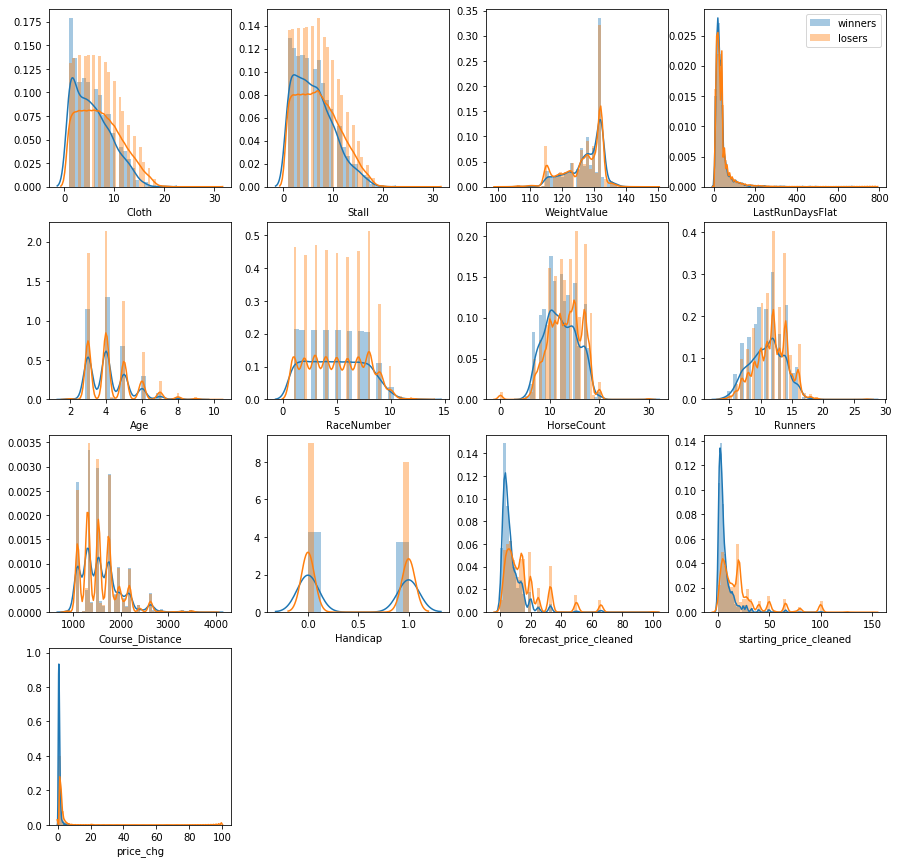

In [55]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(keep):
    plt.subplot(4, 4, i + 1)
    sns.distplot(df_cont[col][df_cont.Won == 1], label='winners')
    sns.distplot(df_cont[col][df_cont.Won == 0], label='losers')
    if i == 3:
        plt.legend()

The above charts start to show how the continuous variables might be able to discrinate between winning and losing horses.  
* Winners a more likely to have a lower `Cloth` number - would be interesting to know what this variable represents!  
* Similarly, when horses are in one of the first 10 stalls they are more likely to win.  (RaceNumber isn't related to the stall)  
* The cleaned price variables do look helpful; horses with lower decimal odds are more likely to win. 
* It looks like races are categorised by Age and weight so that offers no insight, and distance is the same for each race!
* Naturally, handicap levels the playing field so doesn't appear predictive.

## Save processed data

In [56]:
# using pickle to preserve data formats
(df.drop(columns=cols_to_remove)
 .to_pickle((data_path
             .replace('raw', 'processed')
             .replace('csv', 'pickle'))))

## Other considerations, with more time... 
* Really need to capture the horses form. Converting the MeetingDate to a datetime value we can use lag functions to capture prior statistics relating to the horses form, characteristics about the race tracks the horse has won at etc.  
* bayesian probability might be well suited to this problem - the probability of winning given prior knowledge of A) the horse's form & competitors and B) the changing odds.  
* Need to consider the structure of this data... training on all horses to predict the outcome of a single event with a discrete number of outcomes doesn't seem right. There can only be one winner, so I think I might need to apply a softmax function to work out the relative probability for horses entered in the race. Or maybe batch/ group the training data by RaceID.  
* Create some competitor variables, so that the interaction between horse and relative position amongst a field of horses is captured.